In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns

from algorithm_gd import forward, loss_fn, r2_score, gradient_m, gradient_c, get_iteration_vs_accuracy_data

In [2]:
df = pd.read_csv("SOCR-HeightWeight.csv")
df.rename(columns={"Height(Inches)": "X", "Weight(Pounds)": "y"}, inplace=True)
df

,Index,X,y
0,1,65.78331,112.9925
1,2,71.51521,136.4873
2,3,69.39874,153.0269
3,4,68.21660,142.3354
4,5,67.78781,144.2971
...,...,...,...
24995,24996,69.50215,118.0312
24996,24997,64.54826,120.1932
24997,24998,64.69855,118.2655
24998,24999,67.52918,132.2682


In [3]:
df.describe()

,Index,X,y
count,25000.000000,25000.000000,25000.000000
mean,12500.500000,67.993114,127.079421
std,7217.022701,1.901679,11.660898
min,1.000000,60.278360,78.014760
25%,6250.750000,66.704397,119.308675
50%,12500.500000,67.995700,127.157750
75%,18750.250000,69.272958,134.892850
max,25000.000000,75.152800,170.924000


<Axes: xlabel='X', ylabel='y'>

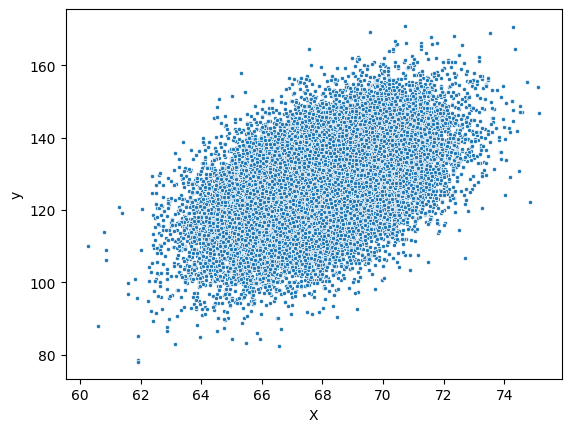

In [4]:
sns.scatterplot(df, x='X', y='y', marker='.')

In [5]:
no_of_nodes = 4

In [6]:
X_median = df['X'].median()
y_median = df['y'].median()

X_median, y_median

(np.float64(67.9957), np.float64(127.15775))

In [7]:
df['node'] = -1
df.head()

,Index,X,y,node
0,1,65.78331,112.9925,-1
1,2,71.51521,136.4873,-1
2,3,69.39874,153.0269,-1
3,4,68.21660,142.3354,-1
4,5,67.78781,144.2971,-1


In [8]:
df.loc[(df['X'] < X_median) & (df['y'] < y_median), 'node'] = 0
df[df['node']==0].count()

Index    8327
X        8327
y        8327
node     8327
dtype: int64

In [9]:
df.loc[(df['X'] >= X_median) & (df['y'] < y_median), 'node'] = 1
df[df['node']==1].count()

Index    4173
X        4173
y        4173
node     4173
dtype: int64

In [10]:
df.loc[(df['X'] < X_median) & (df['y'] >= y_median), 'node'] = 2
df[df['node']==2].count()

Index    4173
X        4173
y        4173
node     4173
dtype: int64

In [11]:
df.loc[(df['X'] >= X_median) & (df['y'] >= y_median), 'node'] = 3
df[df['node']==3].count()

Index    8327
X        8327
y        8327
node     8327
dtype: int64

In [12]:
# check that no any data left to be assigned to a node
assert df[df['node']==-1].count()['node'] == 0

In [13]:
df['partition'] = -1
df.head()

,Index,X,y,node,partition
0,1,65.78331,112.9925,0,-1
1,2,71.51521,136.4873,3,-1
2,3,69.39874,153.0269,3,-1
3,4,68.21660,142.3354,3,-1
4,5,67.78781,144.2971,2,-1


In [14]:
def gen_test_data_partition_frm_df(partitions, df):
    shuffled = df.sample(frac=1)
    result = np.array_split(shuffled, partitions)
    return result

In [15]:
for i in range(no_of_nodes):
    node_filter = (df['node'] == i)
    node_df = df[node_filter]
    partitions = gen_test_data_partition_frm_df(no_of_nodes, node_df)
    for i, p in enumerate(partitions):
        df.loc[df.index.isin(p.index.values), 'partition'] = i

/home/amitgaru2/anaconda3/envs/cvf/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/amitgaru2/anaconda3/envs/cvf/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/amitgaru2/anaconda3/envs/cvf/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/amitgaru2/anaconda3/envs/cvf/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead

In [16]:
df

,Index,X,y,node,partition
0,1,65.78331,112.9925,0,1
1,2,71.51521,136.4873,3,3
2,3,69.39874,153.0269,3,1
3,4,68.21660,142.3354,3,2
4,5,67.78781,144.2971,2,0
...,...,...,...,...,...
24995,24996,69.50215,118.0312,1,1
24996,24997,64.54826,120.1932,0,3
24997,24998,64.69855,118.2655,0,2
24998,24999,67.52918,132.2682,2,1


In [17]:
assert df[df['partition'].isna()].empty

In [18]:
node_params = [ {"m": 0, "c": 0} for i in range(no_of_nodes)]
node_params

[{'m': 0, 'c': 0}, {'m': 0, 'c': 0}, {'m': 0, 'c': 0}, {'m': 0, 'c': 0}]

# Training config

In [19]:
iterations = 1000
L = 0.0001 # learning rate

In [20]:
doubly_stochastic_matrix_config = [
    [1/3, 1/6, 1/6, 1/3],
    [1/6, 1/6, 1/3, 1/3],
    [1/6, 1/3, 1/3, 1/6],
    [1/3, 1/3, 1/6, 1/6]
]

In [21]:
steps_data = []
accuracy_data = [
    [] for i in range(no_of_nodes)
]

In [22]:
def get_node_data_df(node_id):
    return df[df['node'] == node_id]

In [23]:
def get_node_test_data_df(node_id):
    return df[df['partition'] == node_id]

In [24]:
node_df = get_node_data_df(0)
X_node = node_df["X"].array

In [25]:
for i in range(1, iterations+1):
    steps_data.append(i)
    prev_node_params = node_params.copy()
    for node_id in range(no_of_nodes):
        params = node_params[node_id]

        node_df = get_node_data_df(node_id)
        X_node = node_df["X"].array
        y_node = node_df["y"].array

        node_test_df = get_node_test_data_df(node_id)
        X_node_test = node_test_df["X"].array
        y_node_test = node_test_df["y"].array
        y_node_test_mean = node_test_df["y"].mean()

        y_node_test_pred = forward(X_node_test, params)
        y_node_pred = forward(X_node, params)
        
        loss = loss_fn(y_node_test, y_node_test_pred)
        accuracy = r2_score(y_node_test, y_node_test_mean, y_node_test_pred)
        accuracy_data[node_id].append(accuracy)
        # print("Node:", node_id, "| Loss:", round(loss, 6), "| Accuracy:", round(accuracy, 6))
    
        grad_m = gradient_m(X_node, y_node, y_node_pred)
        grad_c = gradient_c(y_node, y_node_pred)

        doubly_st_mt = doubly_stochastic_matrix_config[node_id]
        params['m'] = sum( frac*prev_node_params[i]["m"] for i, frac in enumerate(doubly_st_mt) ) - L * grad_m
        params['c'] = sum( frac*prev_node_params[i]["c"] for i, frac in enumerate(doubly_st_mt) ) - L * grad_c

    # print(node_params)

In [26]:
df['single_node_test_sample'] = 0
df.head()

,Index,X,y,node,partition,single_node_test_sample
0,1,65.78331,112.9925,0,1,0
1,2,71.51521,136.4873,3,3,0
2,3,69.39874,153.0269,3,1,0
3,4,68.21660,142.3354,3,2,0
4,5,67.78781,144.2971,2,0,0


In [27]:
partition = gen_test_data_partition_frm_df(no_of_nodes, df)[random.randint(0, no_of_nodes-1)]
df.loc[df.index.isin(partition.index.values), 'single_node_test_sample'] = 1
df[df['single_node_test_sample'] == 1].count()

/home/amitgaru2/anaconda3/envs/cvf/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Index                      6250
X                          6250
y                          6250
node                       6250
partition                  6250
single_node_test_sample    6250
dtype: int64

In [28]:
X = df["X"].array
y = df["y"].array

X_test = df[df['single_node_test_sample'] == 1]["X"].array
y_test = df[df['single_node_test_sample'] == 1]["y"].array

gd_iterations, gd_accuracy = get_iteration_vs_accuracy_data(X, y, iterations, X_test=X_test, y_test=y_test, L=L)

<Axes: title={'center': 'Iteration vs Accuracy (1000 iterations)'}, xlabel='Iteration', ylabel='Accuracy'>

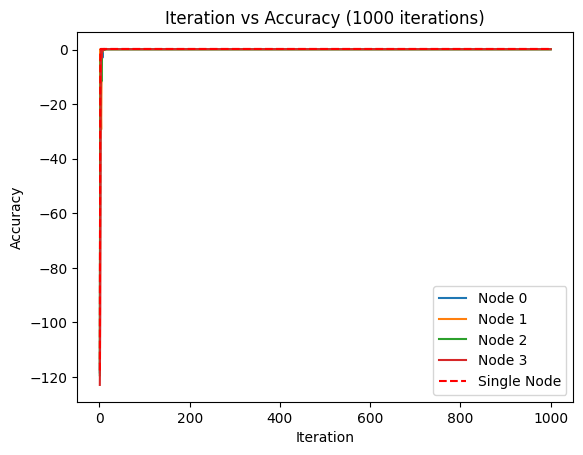

In [29]:
data = {f'Node {i}': accuracy_data[i] for i in range(no_of_nodes)}
df = pd.DataFrame({"Iteration": steps_data, **data})
dfl = pd.melt(df, ["Iteration"], value_name="Accuracy", var_name="Node")
ax = sns.lineplot(data=dfl, x='Iteration', y='Accuracy', hue='Node')
ax.set_title(f"Iteration vs Accuracy ({iterations} iterations)")
sns.lineplot(x=gd_iterations, y=gd_accuracy, linestyle='--', color='r', label='Single Node')

<Axes: title={'center': 'Iteration vs Accuracy (25 iterations)'}, xlabel='Iteration', ylabel='Accuracy'>

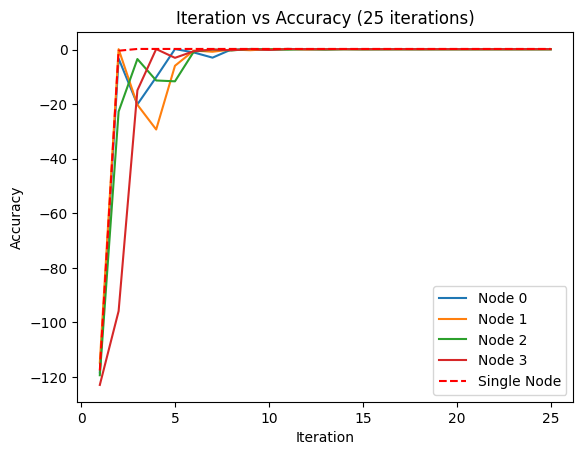

In [44]:
iterations_sample = 25
data = {f'Node {i}': accuracy_data[i][:iterations_sample] for i in range(no_of_nodes)}
df = pd.DataFrame({"Iteration": steps_data[:iterations_sample], **data})
dfl = pd.melt(df, ["Iteration"], value_name="Accuracy", var_name="Node")

ax = sns.lineplot(data=dfl, x='Iteration', y='Accuracy', hue='Node')
ax.set_title(f"Iteration vs Accuracy ({iterations_sample} iterations)")

sns.lineplot(x=gd_iterations[:iterations_sample], y=gd_accuracy[:iterations_sample], linestyle='--', color='r', label='Single Node')

Text(0.5, 1.0, 'Iteration vs Accuracy (1000 iterations) - Gradient descent in single node')

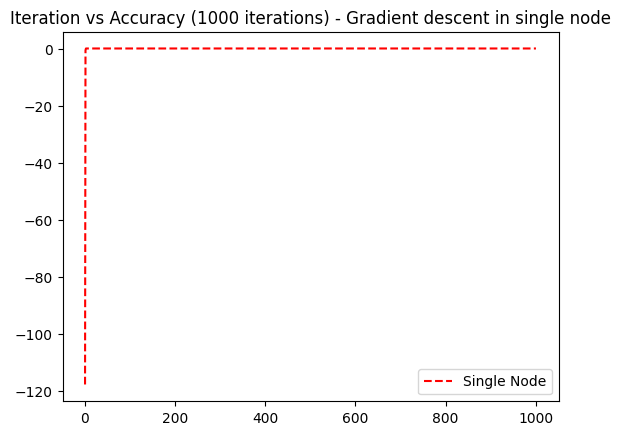

In [31]:
ax = sns.lineplot(x=gd_iterations, y=gd_accuracy, linestyle='--', color='r', label='Single Node')
ax.set_title(f"Iteration vs Accuracy ({iterations} iterations) - Gradient descent in single node")

In [42]:
gd_accuracy[-1]

np.float64(0.21164529002432453)